## Skorch GA network classification example

In [1]:
import numpy as np
from sklearn.datasets import make_classification
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch import NeuralNet
from pyperch.neural.ga_nn import GAModule  
from pyperch.utils.decorators import add_to
from skorch.dataset import unpack_data
import copy
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math

cancer_data = load_breast_cancer()
X, cancer_test, y, cancer_test_label = train_test_split(cancer_data.data, cancer_data.target, test_size=0.2, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)


In [2]:
from skorch.callbacks import EpochScoring 
net = NeuralNetClassifier(
    module=GAModule,
    module__input_dim=30,
    module__output_dim=2,
    module__hidden_units=20,
    module__hidden_layers=2,
    module__population_size=50,
    module__mate_pct=.5,
    module__mutate_pct=.5,
    max_epochs=2,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # use nn.CrossEntropyLoss instead of default nn.NLLLoss
    # for use with raw prediction values instead of log probabilities
    criterion=nn.CrossEntropyLoss(),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)
GAModule.register_ga_training_step()

In [7]:
def test_acc(population_size, mutation_rate, mate_rate):
    net = NeuralNetClassifier(
        module=GAModule,
        module__input_dim=30,
        module__output_dim=2,
        module__hidden_units=20,
        module__hidden_layers=2,
        module__population_size=population_size,
        module__mate_pct=mate_rate,
        module__mutate_pct=mutation_rate,
        max_epochs=20,
        verbose=0,
        callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
        # use nn.CrossEntropyLoss instead of default nn.NLLLoss
        # for use with raw prediction values instead of log probabilities
        criterion=nn.CrossEntropyLoss(),
        # Shuffle training data on each epoch
        iterator_train__shuffle=True,
    )
    GAModule.register_ga_training_step()
    # deactivate skorch-internal train-valid split and verbose logging
    net.set_params(train_split=False, verbose=0, )

    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('net', net),
    ])
    # do a "3-fold cross-validation
    for i in range(3):
        train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=i)
        pipe.fit(train_x, train_y)
        print(pipe.score(test_x, test_y))

test_acc(50, .1, .8)

0.5761589403973509
0.6490066225165563
0.5364238410596026


In [3]:



# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0, )

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

# pipe.fit(X, y)

## Plot learning curves

In [4]:
net.history[:, 'train_loss']

[0.702738652910505,
 0.7027386390245878,
 0.7027386986292325,
 0.7077481888152741,
 0.7054959177970886,
 0.70230582179604,
 0.6836758870344896,
 0.6800016760826111,
 0.676721836577405,
 0.6767218008146181,
 0.6347182881701123,
 0.6347182550273098,
 0.6347182272554754,
 0.624511047902998,
 0.6084035574734866,
 0.6025041347021585,
 0.5898545844214304,
 0.5966124600106544,
 0.5933952246393476,
 0.608048142181648,
 0.608048145718627,
 0.6080481168987987,
 0.6167159472193037,
 0.6167159952960172,
 0.6167009142728952,
 0.6058329402745425,
 0.6022778849025349,
 0.579609783075668,
 0.5779322635996472,
 0.5670738327634204,
 0.5670738304054345,
 0.567073812196543,
 0.5670738509723119,
 0.5670737839007116,
 0.5670738351214063,
 0.5670738336804149,
 0.5670737988346226,
 0.5670738107555515,
 0.5670738196634985,
 0.567073811672546,
 0.5670738200564961,
 0.5670738251654657,
 0.5670738555572845,
 0.5670738230694782,
 0.5670738357764024,
 0.5670737932016562,
 0.5670738336804149,
 0.5670738238554734,
 0

In [45]:
net.history

[{'batches': [{'train_loss': 0.7036334872245789, 'train_batch_size': 128},
   {'train_loss': 0.6997911334037781, 'train_batch_size': 128},
   {'train_loss': 0.7037078738212585, 'train_batch_size': 128},
   {'train_loss': 0.7039709091186523, 'train_batch_size': 71}],
  'epoch': 1,
  'train_batch_count': 4,
  'dur': 0.8423430919647217,
  'train_loss': 0.7026261403010442,
  'train_loss_best': True,
  'train_acc': 0.35384615384615387,
  'train_acc_best': True},
 {'batches': [{'train_loss': 0.7021250128746033, 'train_batch_size': 128},
   {'train_loss': 0.7018142342567444, 'train_batch_size': 128},
   {'train_loss': 0.7027848362922668, 'train_batch_size': 128},
   {'train_loss': 0.7047069072723389, 'train_batch_size': 71}],
  'epoch': 2,
  'train_batch_count': 4,
  'dur': 0.24918818473815918,
  'train_loss': 0.7026260947133158,
  'train_loss_best': True,
  'train_acc': 0.35384615384615387,
  'train_acc_best': False},
 {'batches': [{'train_loss': 0.6994597911834717, 'train_batch_size': 128},

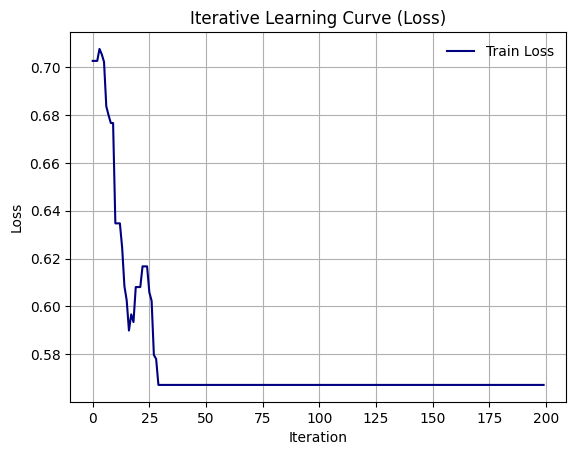

In [5]:
# plot the iterative learning curve (loss)
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
# plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

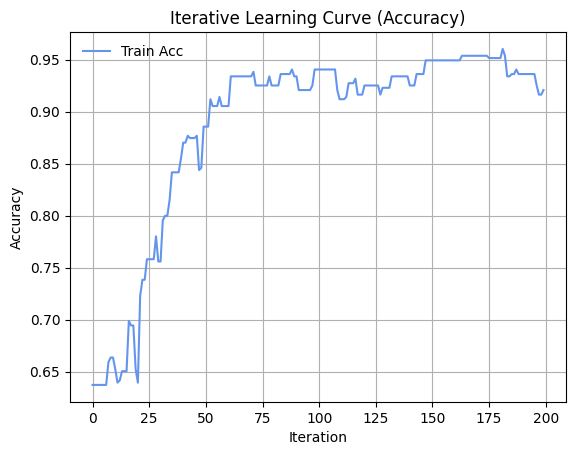

In [41]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
# plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn pipeline with RO

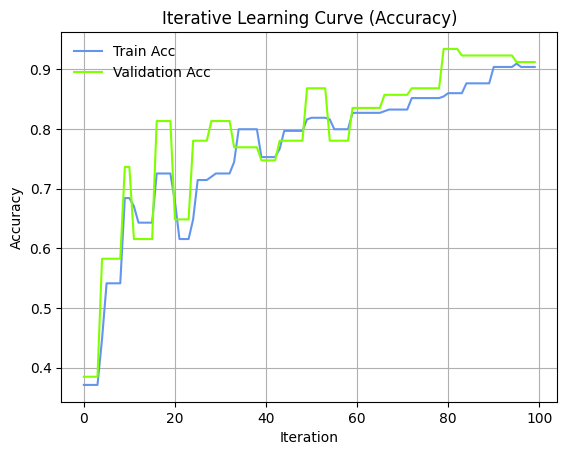

In [44]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)

## grid search

In [4]:
from sklearn.model_selection import GridSearchCV


# module specific parameters need to begin with 'module__'
        # module__population_size=population_size,
        # module__mate_pct=mate_rate,
        # module__mutate_pct=mutation_rate,
default_params = {
    'net__module__input_dim': [30],
    'net__module__output_dim': [2],
    'net__max_epochs': [250, 500],
    'net__module__population_size': [20, 50, 100],
    'net__module__mate_pct': [.2, .5, .8],
    'net__module__mutate_pct': [.2, .5, .8],
}

grid_search_params = {
    # 'net__to_mutate': [30, 60],
    **default_params,
}

gs = GridSearchCV(pipe, grid_search_params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END net__max_epochs=250, net__module__input_dim=30, net__module__mate_pct=0.2, net__module__mutate_pct=0.2, net__module__output_dim=2, net__module__population_size=20; total time=  24.4s
[CV] END net__max_epochs=250, net__module__input_dim=30, net__module__mate_pct=0.2, net__module__mutate_pct=0.2, net__module__output_dim=2, net__module__population_size=20; total time=  22.8s
[CV] END net__max_epochs=250, net__module__input_dim=30, net__module__mate_pct=0.2, net__module__mutate_pct=0.2, net__module__output_dim=2, net__module__population_size=20; total time=  22.8s
[CV] END net__max_epochs=250, net__module__input_dim=30, net__module__mate_pct=0.2, net__module__mutate_pct=0.2, net__module__output_dim=2, net__module__population_size=50; total time=  54.3s
[CV] END net__max_epochs=250, net__module__input_dim=30, net__module__mate_pct=0.2, net__module__mutate_pct=0.2, net__module__output_dim=2, net__module__population_size=5